# Resampling
We have been talking about breaking the data into train/test data sets and cross-validation as a way to avoid overfitting a model to the data. In this exercise, we will try a few different ways. 

In [2]:
# Import our most-used packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import useful ones from the sklearn package 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [3]:
# Set the style for plotting
sns.set_style('white')

## The Data
We have been given sample data from our customers. The data has been aggregated from individual purchases / transactions across the time period (e.g., last year). The goal is to see if we can predict the spending amounts for the next time period (e.g., next year).

In [4]:
# Read in the data and print out its shape
cust = pd.read_csv('./data/customers_clean.csv')
print(cust.shape)

(12266, 11)


In [5]:
# Look at info
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cust_id             12266 non-null  object
 1   join_date           12266 non-null  object
 2   gender              12266 non-null  object
 3   age                 12266 non-null  int64 
 4   marital_status      12266 non-null  object
 5   household_income    12266 non-null  int64 
 6   home_ownership      12266 non-null  object
 7   num_children        12266 non-null  int64 
 8   num_vehicles        12266 non-null  int64 
 9   last_purchase_date  12266 non-null  object
 10  spend               12266 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.0+ MB


In [6]:
# Sample the data
cust.sample(5)

,cust_id,join_date,gender,age,marital_status,household_income,home_ownership,num_children,num_vehicles,last_purchase_date,spend
8708,CUST-423979,2019-10-11 17:34:12,M,35,married,213598,rent,0,1,2021-04-28 02:59:11,4600
8118,CUST-257145,2017-03-21 06:27:41,F,53,married,273958,unknown,5,2,2021-11-27 04:52:39,2542
8546,CUST-308474,2019-10-23 20:03:31,F,34,married,241259,own,3,3,2021-05-30 20:12:01,2476
4724,CUST-695761,2018-02-22 12:32:10,M,22,married,362242,own,2,0,2021-05-21 05:36:15,4177
3181,CUST-119438,2020-02-04 01:53:48,M,34,unmarried,104559,own,3,1,2021-08-27 03:36:52,1925


In [7]:
cust.home_ownership.value_counts()

home_ownership
own        7925
rent       3095
unknown    1246
Name: count, dtype: int64

In [8]:
cust.home_ownership.value_counts(normalize=True)

home_ownership
own        0.646095
rent       0.252323
unknown    0.101582
Name: proportion, dtype: float64

In [9]:
# Using .value_counts is useful for categorical columns
cust.value_counts(subset=['gender', 'marital_status', 'home_ownership'],
                 normalize=True)

gender  marital_status  home_ownership
F       married         own               0.331241
M       married         own               0.148948
F       married         rent              0.132072
        unmarried       own               0.112262
M       married         rent              0.060737
        unmarried       own               0.053644
F       married         unknown           0.051443
        unmarried       rent              0.039214
M       married         unknown           0.023724
        unmarried       rent              0.020300
F       unmarried       unknown           0.018099
M       unmarried       unknown           0.008316
Name: proportion, dtype: float64

In [10]:
# See summary statistics
cust.describe()

,age,household_income,num_children,num_vehicles,spend
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4156.452715
std,10.663234,115752.377718,1.707281,1.697419,1585.348162
min,20.000000,65003.000000,0.000000,0.000000,1468.000000
25%,29.000000,217028.250000,1.000000,1.000000,2788.250000
50%,38.000000,307364.500000,3.000000,3.000000,4169.000000
75%,47.000000,399456.250000,4.000000,4.000000,5296.000000
max,56.000000,489982.000000,5.000000,5.000000,7314.000000


In [11]:
# We can also use .describe() on all columns
# This can be useful to see if we might need to clean the data
cust.describe(include='all')

,cust_id,join_date,gender,age,marital_status,household_income,home_ownership,num_children,num_vehicles,last_purchase_date,spend
count,12266,12266,12266,12266.000000,12266,12266.000000,12266,12266.000000,12266.000000,12266,12266.000000
unique,12266,12265,2,NaN,2,NaN,3,NaN,NaN,12263,NaN
top,CUST-613944,2019-11-30 13:24:14,F,NaN,married,NaN,own,NaN,NaN,2021-01-10 18:04:56,NaN
freq,1,2,8394,NaN,9177,NaN,7925,NaN,NaN,2,NaN
mean,NaN,NaN,NaN,37.864096,NaN,301670.381135,NaN,2.505544,2.503913,NaN,4156.452715
...,...,...,...,...,...,...,...,...,...,...,...
min,NaN,NaN,NaN,20.000000,NaN,65003.000000,NaN,0.000000,0.000000,NaN,1468.000000
25%,NaN,NaN,NaN,29.000000,NaN,217028.250000,NaN,1.000000,1.000000,NaN,2788.250000
50%,NaN,NaN,NaN,38.000000,NaN,307364.500000,NaN,3.000000,3.000000,NaN,4169.000000
75%,NaN,NaN,NaN,47.000000,NaN,399456.250000,NaN,4.000000,4.000000,NaN,5296.000000


## End Result for Input
We want to have all numerical variables. This means we should create *dummy* variables for `gender`, `marital_status`, and `home_ownership`. We also do not need `cust_id` since it is just a unique id (now that we have dropped duplicates). The two date columns could be used to create numerical values, but we will simply ignore them for now.

In [12]:
# We want to create dummy variables for gender, marital_status,
# and home_ownership
pd.get_dummies(cust[['gender','marital_status','home_ownership']],
              dtype=int)

,gender_F,gender_M,marital_status_married,marital_status_unmarried,home_ownership_own,home_ownership_rent,home_ownership_unknown
0,1,0,1,0,0,1,0
1,0,1,1,0,1,0,0
2,1,0,1,0,0,0,1
3,1,0,1,0,1,0,0
4,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...
12261,1,0,1,0,1,0,0
12262,0,1,1,0,1,0,0
12263,0,1,1,0,1,0,0
12264,1,0,1,0,0,1,0


In [13]:
# Let's drop the following columns:
# cust_id, join_date, last_purchase_date
new_cust = cust.drop(columns=['cust_id','join_date','last_purchase_date'])
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            12266 non-null  object
 1   age               12266 non-null  int64 
 2   marital_status    12266 non-null  object
 3   household_income  12266 non-null  int64 
 4   home_ownership    12266 non-null  object
 5   num_children      12266 non-null  int64 
 6   num_vehicles      12266 non-null  int64 
 7   spend             12266 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 766.8+ KB


## Create Dummy Variables

If your `DataFrame` contains categorical (or object) columns, you can call `pd.get_dummies(your_dataframe)` to create the dummy variables for **every** categorical column in the `DataFrame`. Since we deleted the "extra" columns, let's try it on our `new_cust` variable and see the results.

In [14]:
# Create all dummies on all categorical columns
pd.get_dummies(new_cust, dtype=int)

,age,household_income,num_children,num_vehicles,spend,gender_F,gender_M,marital_status_married,marital_status_unmarried,home_ownership_own,home_ownership_rent,home_ownership_unknown
0,31,88153,0,1,3209,1,0,1,0,0,1,0
1,38,80098,1,5,4141,0,1,1,0,1,0,0
2,56,262825,5,5,3930,1,0,1,0,0,0,1
3,22,414209,1,2,5270,1,0,1,0,1,0,0
4,23,268292,3,1,6894,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12261,49,475058,3,0,5268,1,0,1,0,1,0,0
12262,48,347097,4,1,5272,0,1,1,0,1,0,0
12263,32,95384,4,0,2653,0,1,1,0,1,0,0
12264,27,69743,3,3,4200,1,0,1,0,0,1,0


In [15]:
# Really just want k-1 dummies for k categories
# We can use the argument drop_first=True
pd.get_dummies(new_cust, dtype=int, drop_first=True)

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
0,31,88153,0,1,3209,0,0,1,0
1,38,80098,1,5,4141,1,0,0,0
2,56,262825,5,5,3930,0,0,0,1
3,22,414209,1,2,5270,0,0,0,0
4,23,268292,3,1,6894,0,0,0,0
...,...,...,...,...,...,...,...,...,...
12261,49,475058,3,0,5268,0,0,0,0
12262,48,347097,4,1,5272,1,0,0,0
12263,32,95384,4,0,2653,1,0,0,0
12264,27,69743,3,3,4200,0,0,1,0


In [16]:
# Run it again and save it in a new DataFrame
data = pd.get_dummies(new_cust, dtype=int, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
dtypes: int64(9)
memory usage: 862.6 KB


In [17]:
# Look at .describe()
data.describe()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4156.452715,0.315669,0.251834,0.252323,0.101582
std,10.663234,115752.377718,1.707281,1.697419,1585.348162,0.464801,0.434084,0.434364,0.302110
min,20.000000,65003.000000,0.000000,0.000000,1468.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217028.250000,1.000000,1.000000,2788.250000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,307364.500000,3.000000,3.000000,4169.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,399456.250000,4.000000,4.000000,5296.000000,1.000000,1.000000,1.000000,0.000000
max,56.000000,489982.000000,5.000000,5.000000,7314.000000,1.000000,1.000000,1.000000,1.000000


## Some Visualizations

Let's try to look at a few visualizations for the attributes that we have.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'household_income'}>,
        <Axes: title={'center': 'num_children'}>],
       [<Axes: title={'center': 'num_vehicles'}>,
        <Axes: title={'center': 'spend'}>,
        <Axes: title={'center': 'gender_M'}>],
       [<Axes: title={'center': 'marital_status_unmarried'}>,
        <Axes: title={'center': 'home_ownership_rent'}>,
        <Axes: title={'center': 'home_ownership_unknown'}>]], dtype=object)

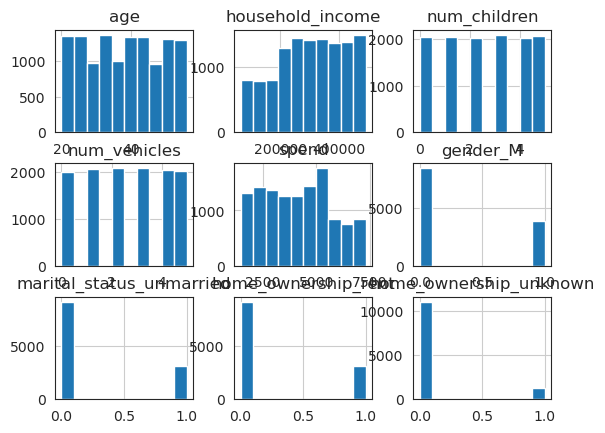

In [18]:
# We can create histograms for each variable in data now
data.hist()

<Axes: >

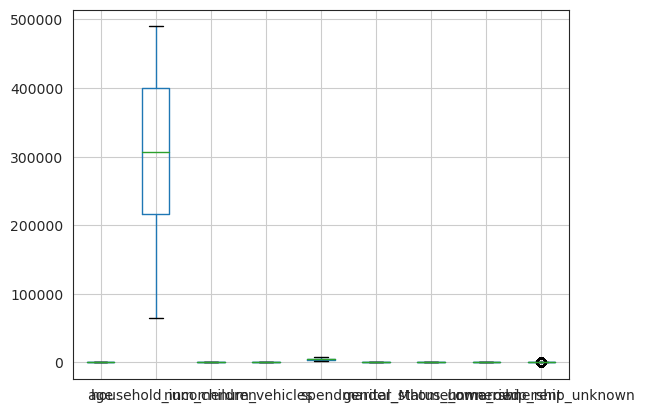

In [19]:
# Try boxplots?
data.boxplot()

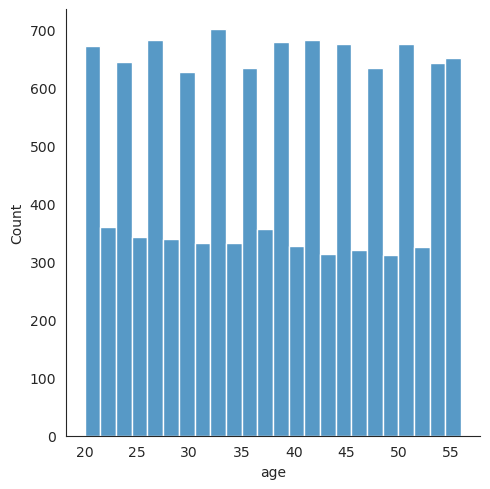

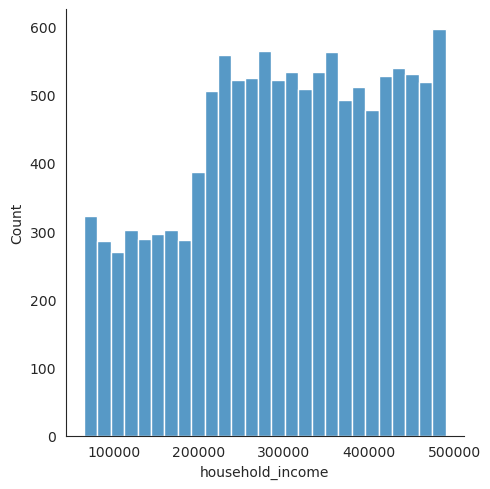

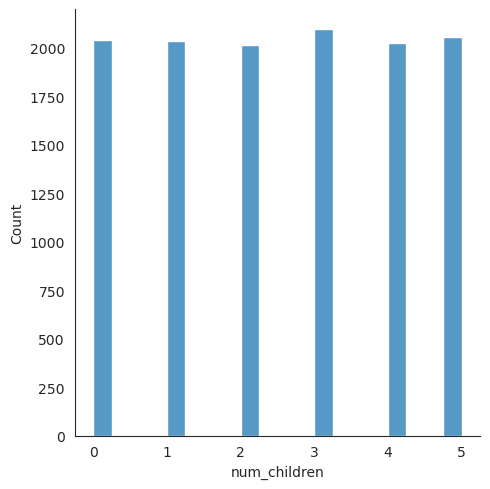

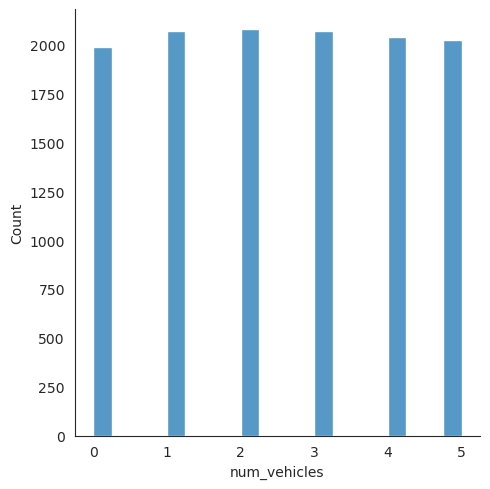

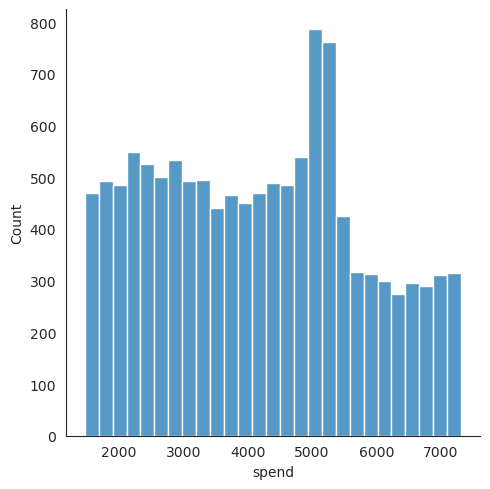

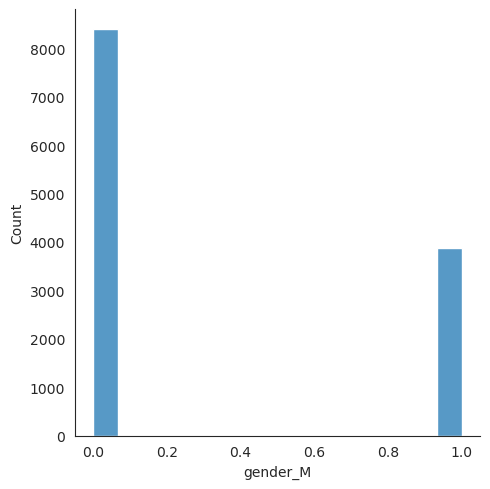

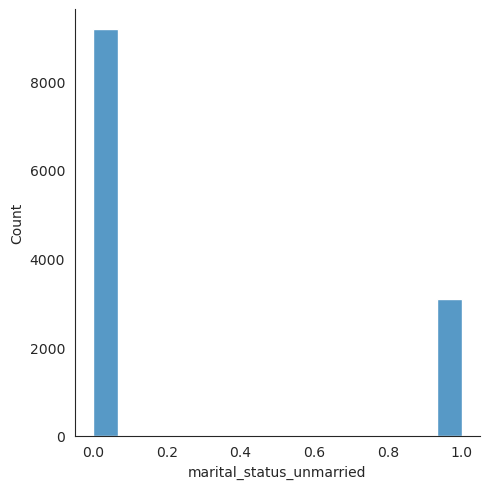

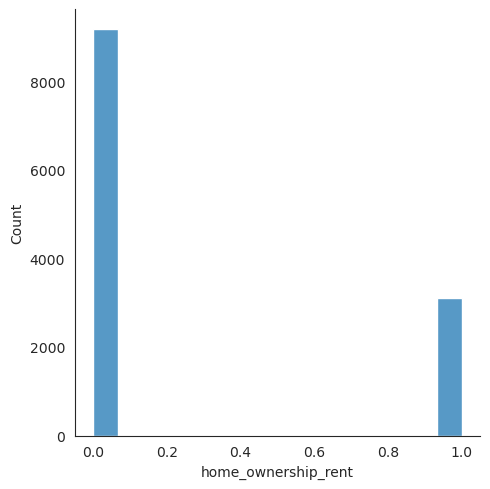

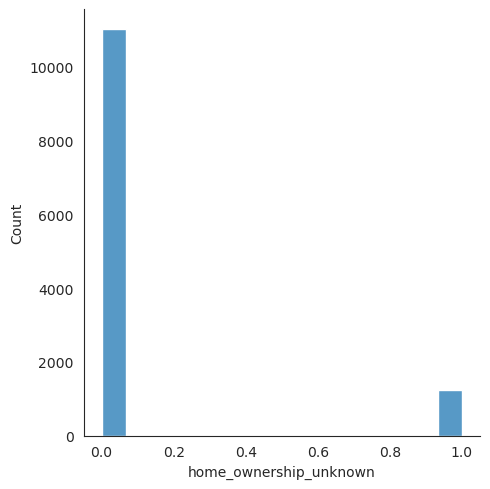

In [20]:
# Could loop over every column and make a displot
for i in data.columns:
    sns.displot(data[i])

In [21]:
# What about correlations?
data.corr()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
age,1.000000,-0.010531,-0.010123,0.011901,0.013474,-0.001806,-0.010414,-0.007488,0.013549
household_income,-0.010531,1.000000,-0.011138,0.007958,0.268363,-0.134408,-0.099774,-0.115327,-0.069592
num_children,-0.010123,-0.011138,1.000000,0.006815,-0.007547,0.000774,0.005762,-0.002601,0.005389
num_vehicles,0.011901,0.007958,0.006815,1.000000,0.000399,-0.002289,0.011111,-0.005597,0.011626
spend,0.013474,0.268363,-0.007547,0.000399,1.000000,-0.327365,-0.253675,-0.270413,-0.155226
gender_M,-0.001806,-0.134408,0.000774,-0.002289,-0.327365,1.000000,0.013698,0.006867,-0.000188
marital_status_unmarried,-0.010414,-0.099774,0.005762,0.011111,-0.253675,0.013698,1.000000,-0.021373,0.006350
home_ownership_rent,-0.007488,-0.115327,-0.002601,-0.005597,-0.270413,0.006867,-0.021373,1.000000,-0.195340
home_ownership_unknown,0.013549,-0.069592,0.005389,0.011626,-0.155226,-0.000188,0.006350,-0.195340,1.000000


<Axes: >

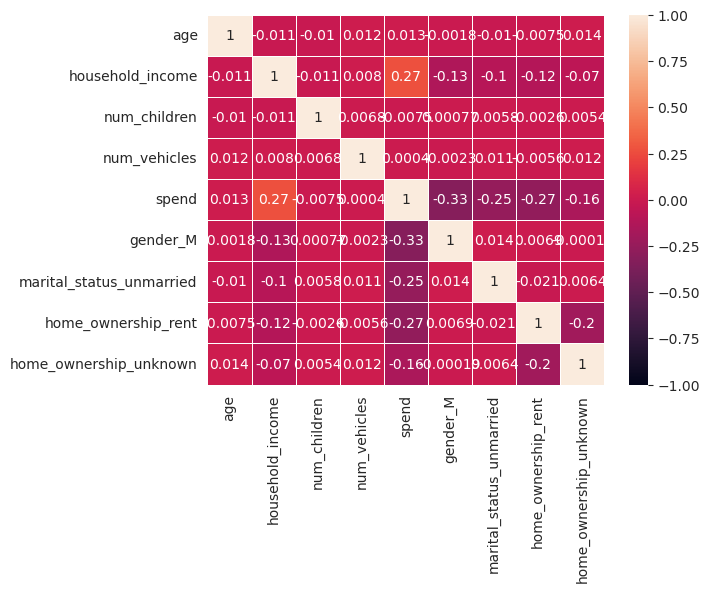

In [22]:
# Create a heatamp of correlations
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.5)

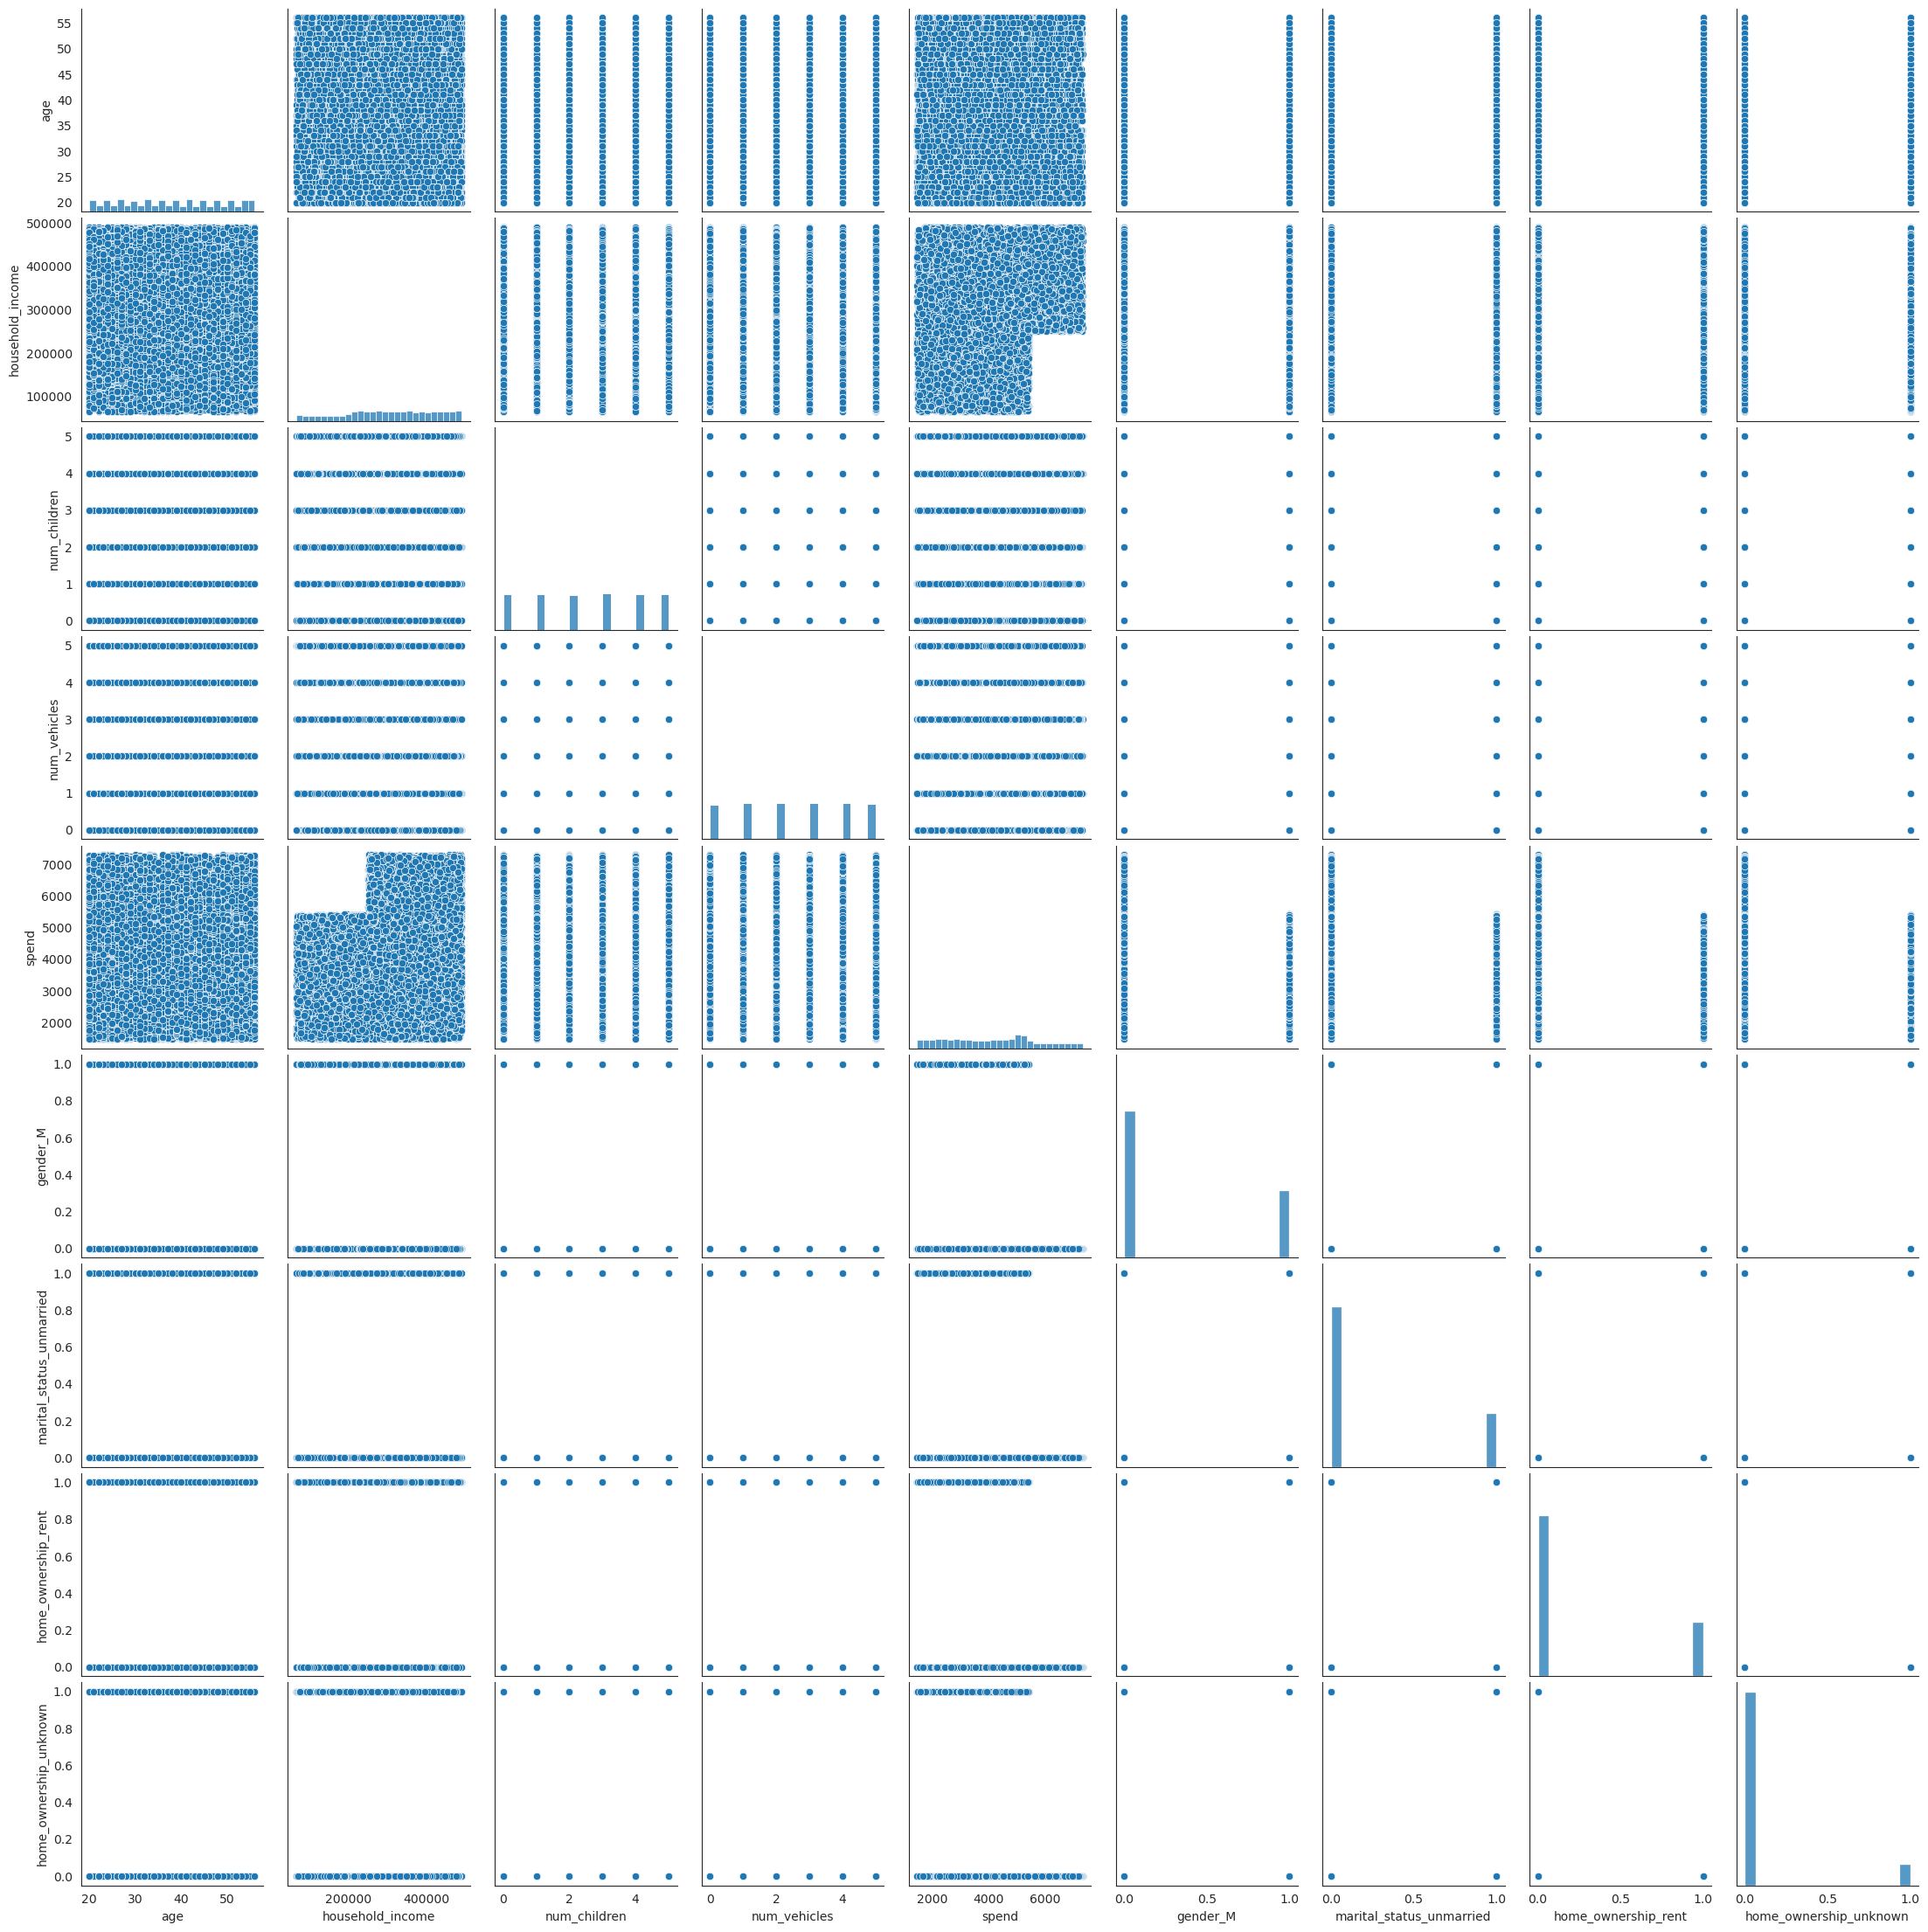

In [23]:
# Try a pairplot
sns.pairplot(data)

## Time for Resampling Attempts
Need to first define `X` and `y`. Then we can try train/test split.

In [24]:
# define the output variable, y
y = data.spend

# define the X
X = data.drop('spend', axis=1)

In [25]:
# Look at shape of X
X.shape

(12266, 8)

In [26]:
# Look at shape of y
y.shape

(12266,)

In [27]:
# Time to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163)

In [28]:
# Look at shape of X_train
X_train.shape

(9812, 8)

In [29]:
# Look at shape of X_test
X_test.shape

(2454, 8)

In [30]:
# Kick out summary statistics for X_train
X_train.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000,9812.000000
mean,37.848349,301149.021199,2.505605,2.504280,0.315430,0.251427,0.254484,0.098757
std,10.694793,115006.856292,1.704877,1.693242,0.464711,0.433855,0.435593,0.298350
min,20.000000,65003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217586.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,306220.500000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,398203.000000,4.000000,4.000000,1.000000,1.000000,1.000000,0.000000
max,56.000000,489982.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Kick out summary statistics for X_test
# Hope these are close to X_train stats
X_test.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,37.927058,303754.971068,2.505297,2.502445,0.316626,0.253464,0.243684,0.112877
std,10.538032,118687.464418,1.717210,1.714365,0.465255,0.435083,0.429392,0.316507
min,20.000000,65206.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,215343.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,312449.000000,3.000000,2.500000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,404501.250000,4.000000,4.000000,1.000000,1.000000,0.000000,0.000000
max,56.000000,489964.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# Time to run a regression
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f'Intercept:    {reg.intercept_}')
print(f'Coefficients: {reg.coef_}')

Intercept:    4390.934589674877
Coefficients: [ 6.42186542e-01  2.17563131e-03  1.50624683e+00  2.44175021e+00
 -1.03509558e+03 -8.67092064e+02 -1.06981243e+03 -1.04578406e+03]


In [34]:
for coef in reg.coef_:
    print(f'{coef:0.4f}')

0.6422
0.0022
1.5062
2.4418
-1035.0956
-867.0921
-1069.8124
-1045.7841


In [35]:
for i in range(len(reg.coef_)):
    print(f'{X_train.columns[i]}: {reg.coef_[i]:0.4f}')

age: 0.6422
household_income: 0.0022
num_children: 1.5062
num_vehicles: 2.4418
gender_M: -1035.0956
marital_status_unmarried: -867.0921
home_ownership_rent: -1069.8124
home_ownership_unknown: -1045.7841


In [36]:
# We can compute the training R-squared, MSE, and RMSE
trainR2 = r2_score(y_train, reg.predict(X_train))
trainMSE = mean_squared_error(y_train, reg.predict(X_train))
trainRMSE = np.sqrt(trainMSE)

print(f'Training R-squared is: {trainR2:.2%}')
print(f'          and MSE is:  {trainMSE:.2f}')
print(f'          and RMSE is: {trainRMSE:.2f}')

Training R-squared is: 31.22%
          and MSE is:  1730164.22
          and RMSE is: 1315.36


In [37]:
# Really interested in the test metrics
pred = reg.predict(X_test)
rSquare = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(f'Test R-squared is: {rSquare:.2%}')
print(f'      and MSE is:  {mse:.2f}')
print(f'      and RMSE is: {rmse:.2f}')

Test R-squared is: 31.07%
      and MSE is:  1725304.12
      and RMSE is: 1313.51


In [38]:
pred

array([3966.78644822, 4227.13686064, 4121.74741821, ..., 3926.15077118,
       5180.65521267, 5289.68640582])

## Try Different Splits
We said that a different 80/20 split will give us different metrics. We hope that they are not "too different". Let's split the full data set 10 different ways and see how the metrics differ. We can also calculate the average MSE, etc.

In [39]:
# Set the random number generator seed 
np.random.seed(131)

# Create 10 different random_state values for splitting
random_states = np.random.choice(range(1,500), 10)
random_states

array([372, 223,  77, 440, 106, 410,  43, 492, 486, 414])

In [40]:
# Let's loop through the randomStates, split the data, fit the model
# Calculate the metrics (capture them)
# Create 6 empty dictionaries
trainR2s = {}
trainMSEs = {}
trainRMSEs = {}
testR2s = {}
testMSEs = {}
testRMSEs = {}

# Use our good friend the for loop
for i in random_states:
    # split the data using randomStates[i] stored in i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                       random_state=i)
    
    # Build and fit the regression model
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    # Make predictions for the training set and calculate metrics
    trainPred = reg.predict(X_train)
    trainR2s[i] = r2_score(y_train, trainPred)
    trainMSEs[i] = mean_squared_error(y_train, trainPred)
    trainRMSEs[i] = np.sqrt(mean_squared_error(y_train, trainPred))
    
    # Make predictions for the test set and calculate metrics
    testPred = reg.predict(X_test)
    testR2s[i] = r2_score(y_test, testPred)
    testMSEs[i] = mean_squared_error(y_test, testPred)
    testRMSEs[i] = np.sqrt(mean_squared_error(y_test, testPred))

In [41]:
# Print out training metric dictionaries
print(trainR2s)
print(trainMSEs)
print(trainRMSEs)

{372: 0.3172186479432496, 223: 0.312860096011504, 77: 0.31980701839309955, 440: 0.31196873685072557, 106: 0.3154271139663085, 410: 0.3121229767037298, 43: 0.30681634191905893, 492: 0.311250956732539, 486: 0.31459278597837037, 414: 0.3061229800811123}
{372: 1710213.725903726, 223: 1722506.0278125252, 77: 1705284.380047128, 440: 1725208.76213007, 106: 1717705.4505343456, 410: 1726410.8609039267, 43: 1738054.6519059648, 492: 1722536.4078255012, 486: 1717941.709854116, 414: 1746753.4336461662}
{372: 1307.7514006506458, 223: 1312.4427712523411, 77: 1305.8653759278282, 440: 1313.4720256366597, 106: 1310.612624132068, 410: 1313.9295494446903, 43: 1318.353007318588, 492: 1312.4543450442386, 486: 1310.7027541949074, 414: 1321.6479991458264}


In [42]:
# Make these dictionaries into DataFrames
trainingR2s = pd.DataFrame.from_dict(trainR2s, orient='index', columns=['Training_R2'])
trainingMSEs = pd.DataFrame.from_dict(trainMSEs, orient='index', columns=['Training_MSE'])
trainingRMSEs = pd.DataFrame.from_dict(trainRMSEs, orient='index', columns=['Training_RMSE'])

# Combine them into a single DataFrame
training_metrics = pd.concat([trainingR2s, trainingMSEs, trainingRMSEs], axis='columns')
training_metrics

,Training_R2,Training_MSE,Training_RMSE
372,0.317219,1.710214e+06,1307.751401
223,0.312860,1.722506e+06,1312.442771
77,0.319807,1.705284e+06,1305.865376
440,0.311969,1.725209e+06,1313.472026
106,0.315427,1.717705e+06,1310.612624
410,0.312123,1.726411e+06,1313.929549
43,0.306816,1.738055e+06,1318.353007
492,0.311251,1.722536e+06,1312.454345
486,0.314593,1.717942e+06,1310.702754
414,0.306123,1.746753e+06,1321.647999


In [ ]:
training_metrics

In [43]:
# Print out test metric dictionaries
print(testR2s)
print(testMSEs)
print(testRMSEs)

{372: 0.29082482993394554, 223: 0.3083610030548882, 77: 0.2806350993432494, 440: 0.3120660887151767, 106: 0.2976192826584739, 410: 0.310877954655276, 43: 0.33229979790191067, 492: 0.314680001596628, 486: 0.30123419563409726, 414: 0.33498290713582435}
{372: 1805916.2428260965, 223: 1755311.0875127825, 77: 1824672.8799973389, 440: 1744443.32725325, 106: 1775931.208729349, 410: 1741081.3315844815, 43: 1693416.2766323555, 492: 1755587.1665732525, 486: 1774420.0650353217, 414: 1659907.7869277073}
{372: 1343.843831263922, 223: 1324.8815371620146, 77: 1350.8045306399215, 440: 1320.7737608134294, 106: 1332.640690032144, 410: 1319.5004098462728, 43: 1301.313289193788, 492: 1324.9857231582732, 486: 1332.073595953062, 414: 1288.3740865632572}


In [44]:
# Make the test dictionaries into DataFrames
testingR2s = pd.DataFrame.from_dict(testR2s, orient='index', columns=['Testing_R2'])
testingMSEs = pd.DataFrame.from_dict(testMSEs, orient='index', columns=['Testing_MSE'])
testingRMSEs = pd.DataFrame.from_dict(testRMSEs, orient='index', columns=['Testing_RMSE'])

# Combine them into a single DataFrame
testing_metrics = pd.concat([testingR2s, testingMSEs, testingRMSEs], axis='columns')
testing_metrics

,Testing_R2,Testing_MSE,Testing_RMSE
372,0.290825,1.805916e+06,1343.843831
223,0.308361,1.755311e+06,1324.881537
77,0.280635,1.824673e+06,1350.804531
440,0.312066,1.744443e+06,1320.773761
106,0.297619,1.775931e+06,1332.640690
410,0.310878,1.741081e+06,1319.500410
43,0.332300,1.693416e+06,1301.313289
492,0.314680,1.755587e+06,1324.985723
486,0.301234,1.774420e+06,1332.073596
414,0.334983,1.659908e+06,1288.374087


In [45]:
# Look at the average RMSE for training and test sets
print(f'Avg Training RMSE: {training_metrics.Training_RMSE.mean():.2f}')
print(f'Avg Test RMSE:     {testing_metrics.Testing_RMSE.mean():.2f}')

Avg Training RMSE: 1312.72
Avg Test RMSE:     1323.92


Text(0.5, 0, 'Split #')

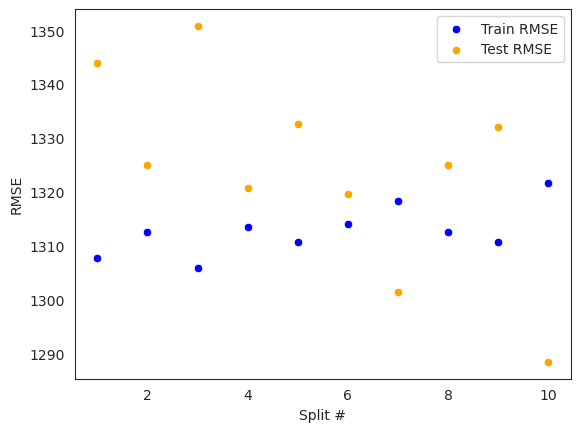

In [47]:
sns.scatterplot(x=list(range(1,11)),
                y=training_metrics.Training_RMSE,
                label='Train RMSE',
                color='blue')
sns.scatterplot(x=list(range(1,11)),
                y=testing_metrics.Testing_RMSE,
                label='Test RMSE',
                color='orange')
plt.ylabel('RMSE')
plt.xlabel('Split #')

# What about Leave-One-Out CV?
Can we do it?

In [48]:
# LeaveOneOut really likes numpy arrays
# Create numpy arrays out X and y
XArray = X.to_numpy()
yArray = y.to_numpy()
print(XArray)

[[    31  88153      0 ...      0      1      0]
 [    38  80098      1 ...      0      0      0]
 [    56 262825      5 ...      0      0      1]
 ...
 [    32  95384      4 ...      0      0      0]
 [    27  69743      3 ...      0      1      0]
 [    34 254675      4 ...      0      0      0]]


In [49]:
# Create a LeaveOneOut object and call get_n_splits
loo = LeaveOneOut()
loo.get_n_splits(XArray)

12266

In [50]:
# Create an empty list to store the test RMSEs from loo
looRMSEs = []

In [51]:
for i, (train_index, test_index) in enumerate(loo.split(XArray)):
    print(f'Fold {i}')
    print(f'   Train index = {train_index}')
    print(f'   Test index  = {test_index}')
    if i == 4:
        break

Fold 0
   Train index = [    1     2     3 ... 12263 12264 12265]
   Test index  = [0]
Fold 1
   Train index = [    0     2     3 ... 12263 12264 12265]
   Test index  = [1]
Fold 2
   Train index = [    0     1     3 ... 12263 12264 12265]
   Test index  = [2]
Fold 3
   Train index = [    0     1     2 ... 12263 12264 12265]
   Test index  = [3]
Fold 4
   Train index = [    0     1     2 ... 12263 12264 12265]
   Test index  = [4]


In [52]:
# Loop over all of the splits
for i, (train_index, test_index) in enumerate (loo.split(XArray)):
    X_train, X_test = XArray[train_index], XArray[test_index]
    y_train, y_test = yArray[train_index], yArray[test_index]
    # Fit the model
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    # make prediction
    pred = reg.predict(X_test)
    # find RMSE and store it
    looRMSEs.append(np.sqrt(mean_squared_error(y_test, pred)))

In [53]:
# see the average RMSE
np.mean(looRMSEs)

1085.1748530164452

### What if we wanted to replicate LOOCV with cross_val_score?
We can do it!

In [54]:
# See what scorers we have for metrics
# import all of sklearn (because I am lazy at this point)
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [55]:
# Create a LinearRegression object
# call cross_val_score
reg = LinearRegression()
cvScores = cross_val_score(reg, X, y, cv=len(X),
                          scoring='neg_mean_squared_error')

In [56]:
# print out average RMSE ... should be same as above
np.mean(np.sqrt(np.absolute(cvScores)))

1085.1748530164452

## Try $K$-Fold CV

Remember $K$ is the number of folds.

In [57]:
# Let's try K=5 fold CV
folds = 5
reg = LinearRegression()
cvMSE = cross_val_score(reg, X, y, cv=folds, scoring='neg_mean_squared_error')
cvR2 = cross_val_score(reg, X, y, cv=folds)

In [58]:
# Print out RMSEs
print(np.sqrt(np.absolute(cvMSE)))

[1332.27332446 1337.01270129 1290.88325692 1283.99773594 1334.51890892]


In [59]:
# Print out R-squareds
print(cvR2)

[0.30195196 0.2886182  0.3243135  0.33473883 0.30461379]


In [60]:
# Print out the average RMSE and average R-squared
print(f'Avg CV RMSE = {np.mean(np.sqrt(np.absolute(cvMSE))):.2f}')
print(f'Avg CV R2   = {np.mean(cvR2):.2%}')

Avg CV RMSE = 1315.74
Avg CV R2   = 31.08%


In [61]:
# We can also use KFold
folds = 5
kf5 = KFold(n_splits=folds)
reg = LinearRegression()
cvMSE2 = cross_val_score(reg, X, y, cv=kf5, scoring='neg_mean_squared_error')
cvR2_2 = cross_val_score(reg, X, y, cv=kf5)

In [62]:
print(f'CV RMSE = {np.mean(np.sqrt(np.absolute(cvMSE2))):.2f}')
print(f'CV R2   = {np.mean(cvR2_2):.2%}')

CV RMSE = 1315.74
CV R2   = 31.08%


In [63]:
# Let's try shuffling the folds
folds = 5
# Set shuffle=True
kf5 = KFold(n_splits=folds, shuffle=True)
reg = LinearRegression()
cvMSE3 = cross_val_score(reg, X, y, cv=kf5, scoring='neg_mean_squared_error')
cvR2_3 = cross_val_score(reg, X, y, cv=kf5)

print(f'CV RMSE = {np.mean(np.sqrt(np.absolute(cvMSE3))):.2f}')
print(f'CV R2   = {np.mean(cvR2_3):.2%}')

CV RMSE = 1315.62
CV R2   = 31.08%


## How Many Folds?

Let's try several different values for $k$, the number of folds.

In [64]:
# Create 2 dictionaries to hold results
avgRMSEs = {}
stdRMSEs = {}

# Loop over multiple k for the folds storing results
for i in range(2, 16):
    reg = LinearRegression()
    cvMSE = cross_val_score(reg, X, y, cv=i,
                           scoring='neg_mean_squared_error')
    avgRMSEs[i] = np.mean(np.sqrt(np.absolute(cvMSE)))
    stdRMSEs[i] = np.std(np.sqrt(np.absolute(cvMSE)))

In [65]:
# Print out the average RMSEs and the average std
print(avgRMSEs)
print(stdRMSEs)

{2: 1316.3360056788188, 3: 1316.6088157226648, 4: 1316.3102135109052, 5: 1315.7371855052138, 6: 1315.9932414404159, 7: 1315.9482760856097, 8: 1315.9868823013321, 9: 1315.7630964218513, 10: 1315.6971847863838, 11: 1315.8153504831414, 12: 1315.722550145368, 13: 1315.7121195120899, 14: 1315.7431817254921, 15: 1315.6888599612453}
{2: 11.684797395178066, 3: 15.890387791710532, 4: 20.653971249073244, 5: 23.25491355942821, 6: 20.65642973637139, 7: 19.56753625091835, 8: 22.37265007699955, 9: 22.97889220947887, 10: 24.569861070458916, 11: 20.97535405439176, 12: 27.61399670915913, 13: 23.751367578390745, 14: 25.58137341567427, 15: 24.815861972563585}


Text(0, 0.5, 'Average RMSE')

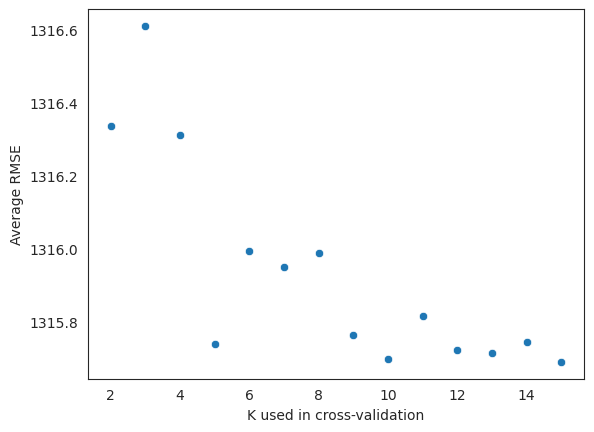

In [66]:
# Plot the avg MSE for each value of k
sns.scatterplot(x=list(avgRMSEs.keys()), y=list(avgRMSEs.values()))
plt.xlabel('K used in cross-validation')
plt.ylabel('Average RMSE')

Text(0, 0.5, 'Standard Deviation of RMSE')

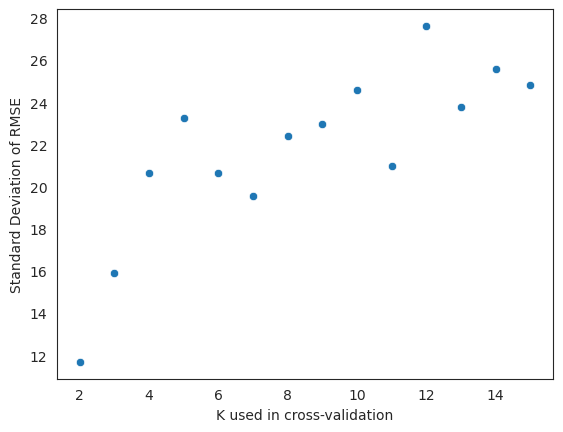

In [67]:
# Plot the standard deviation for each k used
sns.scatterplot(x=list(stdRMSEs.keys()), y=list(stdRMSEs.values()))
plt.xlabel('K used in cross-validation')
plt.ylabel('Standard Deviation of RMSE')

## What About Predicting

You have been given a new list of customers. You want to predict how much they will spend next year. What should we do? The file is in `new_cust.csv`.

**&copy; 2022 - Present: Matthew D. Dean, Ph.D.   
Clinical Associate Professor of Business Analytics at William \& Mary.**